<a href="https://colab.research.google.com/github/adelatanca/Bitcoin-Price-Prediction-ML/blob/main/BTC_Random_Forest_Tanca_Adela.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy matplotlib scikit-learn scipy plotly

# **Large data set**

Train data RMSE:  332.9193441360445
Train data MAE:  189.31686907138283
Train data MAPE:  0.5858457180253746
Train data R-squared:  0.9995362238051124
Train data Accuracy:  99.95362238051125
Train data Directional Accuracy:  77.71689497716895
-------------------------------------------------------------------------------------
Test data RMSE:  721.9954006262182
Test data MAE:  562.5562454381247
Test data MAPE:  1.820010743709582
Test data R-squared:  0.9891425746850947
Test data Accuracy:  98.91425746850948
Test data Directional Accuracy:  38.82783882783883


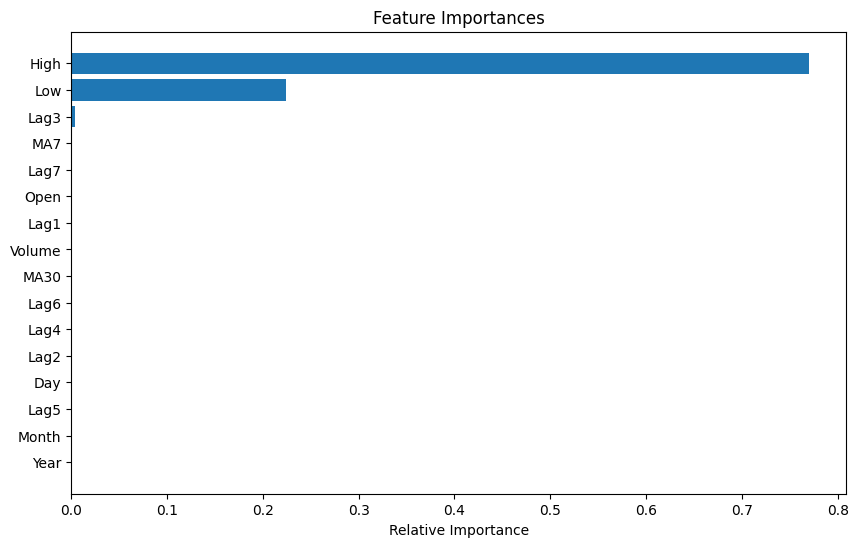


               Metric      Train Data       Test Data
                RMSE      332.919344      721.995401
                 MAE      189.316869      562.556245
                MAPE        0.585846        1.820011
           R-squared        0.999536        0.989143
            Accuracy       99.953622       98.914257
Directional Accuracy       77.716895       38.827839


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint
import plotly.graph_objects as go
import math

# Load the data
df = pd.read_csv('BTC-USD.csv')

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Create additional time-based features
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

# Add moving averages
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA30'] = df['Close'].rolling(window=30).mean()

# Add lag features
for lag in range(1, 8):
    df[f'Lag{lag}'] = df['Close'].shift(lag)

# Drop rows with NaN values
df.dropna(inplace=True)

# Define features and target
X = df[['Open', 'High', 'Low', 'Volume', 'Year', 'Month', 'Day', 'MA7', 'MA30'] + [f'Lag{lag}' for lag in range(1, 8)]]
y = df['Close']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the RandomForest model
model = RandomForestRegressor(random_state=42)

# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': [10, 15, 25, 20],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(2, 6),
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42)
random_search.fit(X_train_scaled, y_train)
best_params = random_search.best_params_

# Use the best parameters to define the model
model = RandomForestRegressor(**best_params, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = math.sqrt(train_mse)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
train_r2 = r2_score(y_train, y_train_pred)
train_accuracy = train_r2 * 100

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = math.sqrt(test_mse)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
test_r2 = r2_score(y_test, y_test_pred)
test_accuracy = test_r2 * 100
# Calculate Directional Accuracy for test data
test_direction = np.sign(np.diff(y_test.values))
test_predict_direction = np.sign(np.diff(y_test_pred))
test_direction_accuracy = np.mean(test_direction == test_predict_direction) * 100

# Calculate Directional Accuracy for train data
train_direction = np.sign(np.diff(y_train.values))
train_predict_direction = np.sign(np.diff(y_train_pred))
train_direction_accuracy = np.mean(train_direction == train_predict_direction) * 100

print("Train data RMSE: ", train_rmse)
print("Train data MAE: ", train_mae)
print("Train data MAPE: ", train_mape)
print("Train data R-squared: ", train_r2)
print("Train data Accuracy: ", train_accuracy)
print("Train data Directional Accuracy: ", train_direction_accuracy)
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", test_rmse)
print("Test data MAE: ", test_mae)
print("Test data MAPE: ", test_mape)
print("Test data R-squared: ", test_r2)
print("Test data Accuracy: ", test_accuracy)
print("Test data Directional Accuracy: ", test_direction_accuracy)


# Plot actual vs predicted values with Plotly for interactivity
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_test.index,
    y=y_test,
    mode='lines',
    name='Actual',
    line=dict(color='blue'),
    marker=dict(size=5)
))

fig.add_trace(go.Scatter(
    x=y_test.index,
    y=y_test_pred,
    mode='lines',
    name='Predicted',
    line=dict(color='red'),
    marker=dict(size=5)
))

fig.update_layout(
    title='Actual vs Predicted Close Price',
    xaxis_title='Date',
    yaxis_title='Close Price',
    legend_title='Legend',
    hovermode='x unified'
)

fig.show()

# Plot feature importances
importances = model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE', 'R-squared', 'Accuracy', 'Directional Accuracy'],
    'Train Data': [train_rmse, train_mae, train_mape, train_r2, train_accuracy, train_direction_accuracy ],
    'Test Data': [test_rmse, test_mae, test_mape, test_r2, test_accuracy, test_direction_accuracy]
})

# Display the DataFrame with more spaces between columns
print("\n", metrics_df.to_string(index=False, col_space=15))


# Reduced data set

Train data RMSE:  274.12311956516646
Train data MAE:  137.48424421913097
Train data MAPE:  0.7082392592607173
Train data R-squared:  0.9997101519430545
Train data Accuracy:  99.97101519430545
Train data Directional Accuracy:  84.1642228739003
-------------------------------------------------------------------------------------
Test data RMSE:  1066.0484970879406
Test data MAE:  771.5875563659783
Test data MAPE:  1.623514208661378
Test data R-squared:  0.9832312799499316
Test data Accuracy:  98.32312799499317
Test data Directional Accuracy:  65.88235294117646


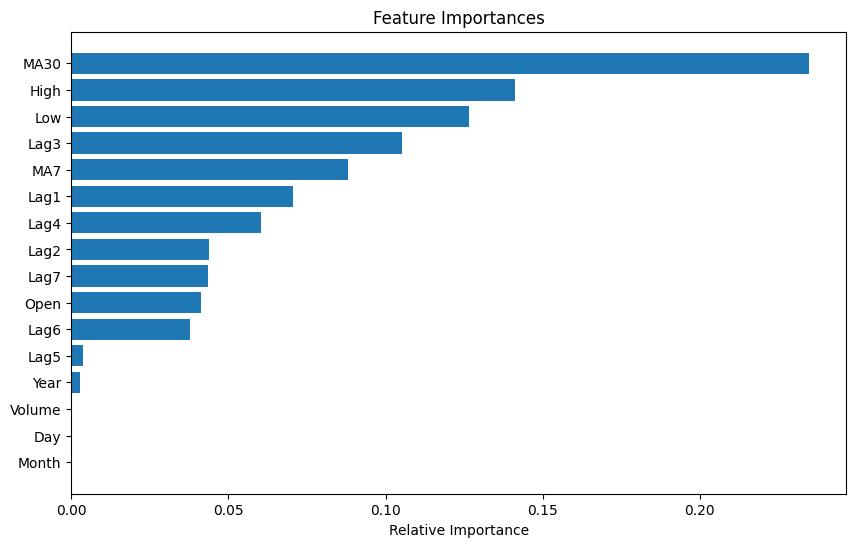


               Metric      Train Data       Test Data
                RMSE      274.123120     1066.048497
                 MAE      137.484244      771.587556
                MAPE        0.708239        1.623514
           R-squared        0.999710        0.983231
            Accuracy       99.971015       98.323128
Directional Accuracy       84.164223       65.882353


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint
import plotly.graph_objects as go
import math

# Load the data
df = pd.read_csv('BTC-USD-random-forest.csv')

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Create additional time-based features
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

# Add moving averages
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA30'] = df['Close'].rolling(window=30).mean()

# Add lag features
for lag in range(1, 8):
    df[f'Lag{lag}'] = df['Close'].shift(lag)

# Drop rows with NaN values
df.dropna(inplace=True)

# Define features and target
X = df[['Open', 'High', 'Low', 'Volume', 'Year', 'Month', 'Day', 'MA7', 'MA30'] + [f'Lag{lag}' for lag in range(1, 8)]]
y = df['Close']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the RandomForest model
model = RandomForestRegressor(random_state=42)

# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': [10, 15, 25, 20],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(2, 6),
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42)
random_search.fit(X_train_scaled, y_train)
best_params = random_search.best_params_

# Use the best parameters to define the model
model = RandomForestRegressor(**best_params, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = math.sqrt(train_mse)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
train_r2 = r2_score(y_train, y_train_pred)
train_accuracy = train_r2 * 100

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = math.sqrt(test_mse)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
test_r2 = r2_score(y_test, y_test_pred)
test_accuracy = test_r2 * 100
# Calculate Directional Accuracy for test data
test_direction = np.sign(np.diff(y_test.values))
test_predict_direction = np.sign(np.diff(y_test_pred))
test_direction_accuracy = np.mean(test_direction == test_predict_direction) * 100

# Calculate Directional Accuracy for train data
train_direction = np.sign(np.diff(y_train.values))
train_predict_direction = np.sign(np.diff(y_train_pred))
train_direction_accuracy = np.mean(train_direction == train_predict_direction) * 100

print("Train data RMSE: ", train_rmse)
print("Train data MAE: ", train_mae)
print("Train data MAPE: ", train_mape)
print("Train data R-squared: ", train_r2)
print("Train data Accuracy: ", train_accuracy)
print("Train data Directional Accuracy: ", train_direction_accuracy)
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", test_rmse)
print("Test data MAE: ", test_mae)
print("Test data MAPE: ", test_mape)
print("Test data R-squared: ", test_r2)
print("Test data Accuracy: ", test_accuracy)
print("Test data Directional Accuracy: ", test_direction_accuracy)

# Plot actual vs predicted values with Plotly for interactivity
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_test.index,
    y=y_test,
    mode='lines',
    name='Actual',
    line=dict(color='blue'),
    marker=dict(size=5)
))

fig.add_trace(go.Scatter(
    x=y_test.index,
    y=y_test_pred,
    mode='lines',
    name='Predicted',
    line=dict(color='red'),
    marker=dict(size=5)
))

fig.update_layout(
    title='Actual vs Predicted Close Price',
    xaxis_title='Date',
    yaxis_title='Close Price',
    legend_title='Legend',
    hovermode='x unified'
)

fig.show()

# Plot feature importances
importances = model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE', 'R-squared', 'Accuracy', 'Directional Accuracy'],
    'Train Data': [train_rmse, train_mae, train_mape, train_r2, train_accuracy, train_direction_accuracy ],
    'Test Data': [test_rmse, test_mae, test_mape, test_r2, test_accuracy, test_direction_accuracy]
})

# Display the DataFrame with more spaces between columns
print("\n", metrics_df.to_string(index=False, col_space=15))
